## IN3050/IN4050 Mandatory Assignment 2, 2023: Supervised Learning

### Rules

Before you begin the exercise, review the rules at this website:

- https://www.uio.no/english/studies/examinations/compulsory-activities/mn-ifi-mandatory.html 

in particular the paragraph on cooperation. This is an individual assignment. You are not allowed to deliver together or copy/share source-code/answers with others. Read also the "Routines for handling suspicion of cheating and attempted cheating at the University of Oslo": 
- https://www.uio.no/english/studies/examinations/cheating/index.html 

By submitting this assignment, you confirm that you are familiar with the rules and the consequences of breaking them.

### Delivery

**Deadline**: Friday, March 24, 2023, 23:59

Your submission should be delivered in Devilry. You may redeliver in Devilry before the deadline, but include all files in the last delivery, as only the last delivery will be read. You are recommended to upload preliminary versions hours (or days) before the final deadline.

### What to deliver?

You are recommended to solve the exercise in a Jupyter notebook, but you might solve it in a Python program if you prefer.

#### Alternative 1
If you choose Jupyter, you should deliver the notebook. You should answer all questions and explain what you are doing in Markdown. Still, the code should be properly commented. The notebook should contain results of your runs. In addition, you should make a pdf of your solution which shows the results of the runs. (If you can't export: notebook -> latex -> pdf on your own machine, you may do this on the IFI linux machines.)

#### Alternative 2
If you prefer not to use notebooks, you should deliver the code, your run results, and a pdf-report where you answer all the questions and explain your work.

Here is a list of *absolutely necessary* (but not sufficient) conditions to get the assignment marked as passed:

- You must deliver your code (python file or notebook) you used to solve the assignment.
- The code used for making the output and plots must be included in the assignment. 
- You must include example runs that clearly shows how to run all implemented functions and methods.
- All the code (in notebook cells or python main-blocks) must run. If you have unfinished code that crashes, please comment it out and document what you think causes it to crash. 
- You must also deliver a pdf of the code, outputs, comments and plots as explained above.

Your report/notebook should contain your name and username.

Deliver one single zipped folder (.zip, .tgz or .tar.gz) which contains your complete solution.

Important: if you weren’t able to finish the assignment, use the PDF report/Markdown to elaborate on what you’ve tried and what problems you encountered. Students who have made an effort and attempted all parts of the assignment will get a second chance even if they fail initially. This exercise will be graded PASS/FAIL.

### Goals of the assignment
The goal of this assignment is to get a better understanding of supervised learning with gradient descent. It will, in particular, consider the similarities and differences between linear classifiers and multi-layer feed forward networks (multi-layer perceptron, MLP) and the differences and similarities between binary and multi-class classification. A main part will be dedicated to implementing and understanding the backpropagation algorithm. 

### Tools
The aim of the exercises is to give you a look inside the learning algorithms. You may freely use code from the weekly exercises and the published solutions. You should not use ML libraries like scikit-learn or tensorflow.

You may use tools like NumPy and Pandas, which are not specific ML-tools.

The given precode uses NumPy. You are recommended to use NumPy since it results in more compact code, but feel free to use pure python if you prefer. 

### Beware
There might occur typos or ambiguities. This is a revised assignment compared to earlier years, and there might be new typos. If anything is unclear, do not hesitate to ask. Also, if you think some assumptions are missing, make your own and explain them!

### Initialization

In [249]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn #for datasets

## Datasets

We start by making a synthetic dataset of 2000 datapoints and five classes, with 400 individuals in each class. (See https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html regarding how the data are generated.) We choose to use a synthetic dataset---and not a set of natural occuring data---because we are mostly interested in properties of the various learning algorithms, in particular the differences between linear classifiers and multi-layer neural networks together with the difference between binary and multi-class data.

When we are doing experiments in supervised learning, and the data are not already split into training and test sets, we should start by splitting the data. Sometimes there are natural ways to split the data, say training on data from one year and testing on data from a later year, but if that is not the case, we should shuffle the data randomly before splitting. (OK, that is not necessary with this particular synthetic data set, since it is already shuffled by default by scikit, but that will not be the case with real-world data.) We should split the data so that we keep the alignment between X and t, which may be achieved by shuffling the indices. We split into 50% for training, 25% for validation, and 25% for final testing. The set for final testing *must not be used* till the end of the assignment in part 3.

We fix the seed both for data set generation and for shuffling, so that we work on the same datasets when we rerun the experiments. This is done by the `random_state` argument and the `rng = np.random.RandomState(2022)`.

In [250]:
from sklearn.datasets import make_blobs
X, t_multi = make_blobs(n_samples=[400,400,400, 400, 400], 
                        centers=[[0,1],[4,2],[8,1],[2,0],[6,0]], 
                        cluster_std=[1.0, 2.0, 1.0, 0.5, 0.5],
                        n_features=2, random_state=2022)

In [251]:
indices = np.arange(X.shape[0])
rng = np.random.RandomState(2022)
rng.shuffle(indices)
indices[:10]

array([1018, 1295,  643, 1842, 1669,   86,  164, 1653, 1174,  747])

In [252]:
X_train = X[indices[:1000],:]
X_val = X[indices[1000:1500],:]
X_test = X[indices[1500:],:]
t_multi_train = t_multi[indices[:1000]]
t_multi_val = t_multi[indices[1000:1500]]
t_multi_test = t_multi[indices[1500:]]

Next, we will  make a second dataset by merging classes in (X,t) into two classes and call the new set (X, t2). This will be a binary set.
We now have two datasets:

- Binary set: `(X, t2)`
- Multi-class set: `(X, t_multi)`

In [253]:
t2_train = t_multi_train >= 3
t2_train = t2_train.astype('int')
t2_val = (t_multi_val >= 3).astype('int')
t2_test = (t_multi_test >= 3).astype('int')

We can plot the two traning sets.

Text(0.5, 1.0, 'Multi-class set')

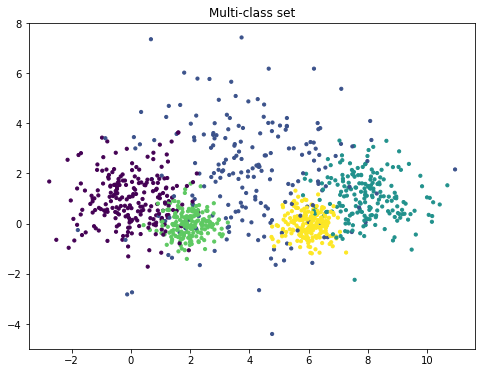

In [254]:
plt.figure(figsize=(8,6)) # You may adjust the size
plt.scatter(X_train[:, 0], X_train[:, 1], c=t_multi_train, s=10.0)
plt.title('Multi-class set')

Text(0.5, 1.0, 'Binary set')

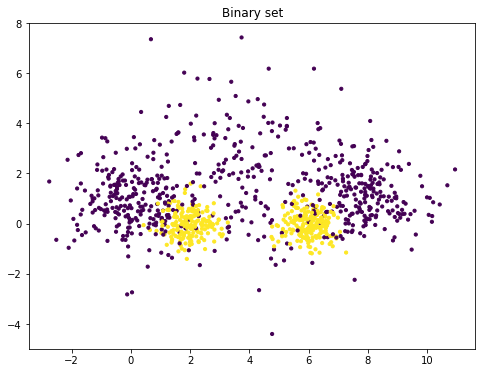

In [255]:
plt.figure(figsize=(8,6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=t2_train, s=10.0)
plt.title('Binary set')

# Part I: Linear classifiers
## Linear regression

We see that that set (X, t2) is far from linearly separable, and we will explore how various classifiers are able to handle this. We start with linear regression. You may make your own implementation from scratch or start with the solution to the weekly exercise set 7. 
We include it here with a little added flexibility.

In [256]:
def add_bias(X, bias):
    """X is a Nxm matrix: N datapoints, m features
    bias is a bias term, -1 or 1. Use 0 for no bias
    Return a Nx(m+1) matrix with added bias in position zero
    """
    N = X.shape[0]
    biases = np.ones((N, 1))*bias # Make a N*1 matrix of bias-s
    # Concatenate the column of biases in front of the columns of X.
    return np.concatenate((biases, X), axis  = 1) 

In [257]:
class NumpyClassifier():
    """Common methods to all numpy classifiers --- if any"""

In [267]:
class NumpyLinRegClass(NumpyClassifier):

    def __init__(self, bias=-1):
        self.bias=bias
    
    def fit(self, X_train, t_train, eta = 0.1, epochs=10):
        """X_train is a Nxm matrix, N data points, m features
        t_train is avector of length N,
        the targets values for the training data"""
        
        if self.bias:
            X_train = add_bias(X_train, self.bias)
            
        (N, m) = X_train.shape
        #print(X_train.shape[1])

        
        self.weights = weights = np.zeros(m)
        self.lossPerEp = []
        self.accuracyPerEp = []
        
        #Implementing mse
        def mse(X, t):
            loss = (t - X @ self.weights)**2
            mean_per_ep = np.mean(loss)
            return mean_per_ep
        
        #Accuracy function
        def accur(X_train,t_train):
            accuracy=np.mean((X_train@weights>0.5)==t2_train)
            return accuracy
            
        
        
        for e in range(epochs):
            weights -= eta / N *  X_train.T @ (X_train @ weights - t_train)
            self.lossPerEp.append(mse(X_train, t2_train))
            self.accuracyPerEp.append(accur(X_train,t2_train))
    
    def predict(self, X, threshold=0.5):
        """X is a Kxm matrix for some K>=1
        predict the value for each point in X"""
        if self.bias:
            X = add_bias(X, self.bias)
        ys = X @ self.weights
        return ys > threshold

We can train and test a first classifier.

In [268]:
def accuracy_func(predicted, gold):
    return np.mean(predicted == gold)

In [269]:
cl = NumpyLinRegClass()
cl.fit(X_train, t2_train)
accuracy_func(cl.predict(X_val), t2_val)

0.522

The following is a small procedure which plots the data set together with the decision boundaries. 
You may modify the colors and the rest of the graphics as you like.
The procedure will also work for multi-class classifiers

In [270]:
def plot_decision_regions(X, t, clf=[], size=(8,6)):
    """Plot the data set (X,t) together with the decision boundary of the classifier clf"""
    # The region of the plane to consider determined by X
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # Make a make of the whole region
    h = 0.02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Classify each meshpoint.
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=size) # You may adjust this

    # Put the result into a color plot
    plt.contourf(xx, yy, Z, alpha=0.2, cmap = 'Paired')

    plt.scatter(X[:,0], X[:,1], c=t, s=10.0, cmap='Paired')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision regions")
    plt.xlabel("x0")
    plt.ylabel("x1")

#    plt.show()

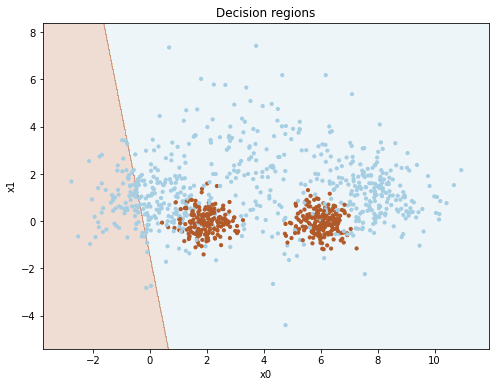

In [271]:
plot_decision_regions(X_train, t2_train, cl)

### Task: Tuning

The result is far from impressive. 
Remember that a classifier which always chooses the majority class will have an accuracy of 0.6 on this data set.

Your task is to try various settings for the two training hyper-parameters, *eta* and *epochs*, to get the best accuracy on the validation set. 

Report how the accuracy vary with the hyper-parameter settings. It it not sufficient to give the final hyperparemters. You must also show how you found them  and results for alternative values you tried aout.

When you are satisfied with the result, you may plot the decision boundaries, as above.

In [272]:
#I create a function, because we have to tune the hyperparameters for other tasks aswell. 
def exp_hyp_parameters(X):
    eta_val = np.arange(0.01, 0.10, 0.01)
    epochs_val = np.arange(0, 300, 10)
    best_eta = None
    best_epochs = None
    i , k = len(eta_val)*len(epochs_val), 0
    a_succ, b_succ, acc_suc = np.zeros(i), np.zeros(i),np.zeros(i) #Store the values in numpy arrays


    # Loop over all possible combinations of hyperparameters
    best_acc = 0.0
    for eta in eta_val:
        for epochs in epochs_val:
            # Train model with current hyperparameters
            cl = NumpyLinRegClass()
            cl.fit(X, t2_train, eta, epochs)

            # Evaluate model on validation set
            val_accuracy = accuracy(cl.predict(X_val), t2_val)

            a_succ[k] = eta; b_succ[k] = epochs; acc_suc[k] = val_accuracy

            # Update best hyperparameters if new high score achieved
            if val_accuracy > best_acc:
                best_acc = val_accuracy
                best_eta = eta
                best_epochs = epochs

            k+=1
    return best_eta, best_epochs, a_succ, b_succ, acc_suc, best_acc

# Train final model with best hyperparameters on entire dataset
best_eta_epoch = NumpyLinRegClass()

eta_func, epochs_func, a_succ_func, b_succ_func, acc_succ_func, best_acc_func = exp_hyp_parameters(X_train)

best = best_eta_epoch.fit(X_train, t2_train, eta= eta_func, epochs= epochs_func)

accuracy(best_eta_epoch.predict(X_val), t2_val)


0.704

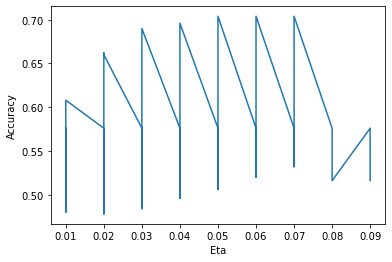

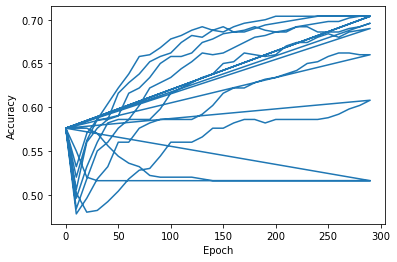

Eta : 0.05 
Epoch: 280
Max accuracy : 0.704


In [273]:
plt.plot(a_succ_func,acc_succ_func)
plt.xlabel('Eta')
plt.ylabel('Accuracy')
plt.show()
plt.clf()

plt.plot(b_succ_func,acc_succ_func)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

print(f'Eta : {eta_func} \nEpoch: {epochs_func}')
print(f'Max accuracy : {best_acc_func}')

The accuracy varies with different choices of Eta and Epoch. I found that the best accuracy is 0.704 with an Eta of 0.05 and Epoch: 280. The graphs show how accuracy varies with different eta and epoch. They look different then the ones i had when I changed both Eta and Epoch at the same time, but I tried to keep one of them still while changing the other, because I got it as a comment. 

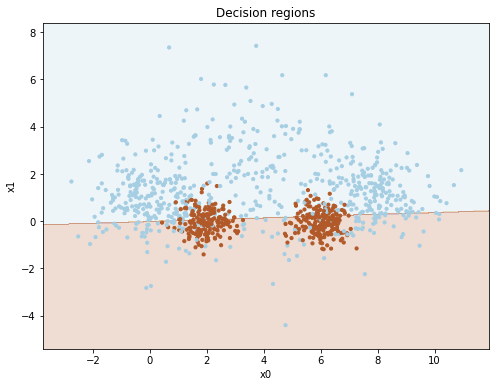

In [274]:
plot_decision_regions(X_train, t2_train, best_eta_epoch)

### Task: Loss
The linear regression classifier is trained with mean squared error loss. So far, we have not calculated the loss explicitly in the code. Extend the code to calculate the loss on the training set for each epoch and to store the losses such that the losses can be inspected after training. 

Also extend the classifier to calculate the accuracy on the training data after each epoch.

Train a classifier with your best settings from last point. After training, plot the loss as a function of the number of epochs. Then plot the accuracy as a function of the number of epochs.

Comment on what you see: Are the function monotone? Is this as expected?

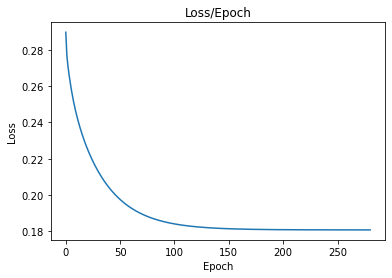

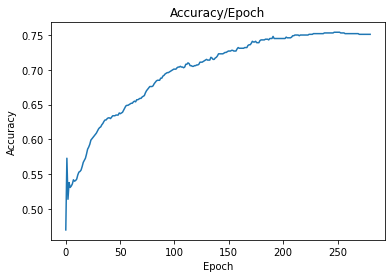

In [275]:
c2 = NumpyLinRegClass()
c2.fit(X_train, t2_train,0.05,280) #Use the parameters that was found


x_1 = np.linspace(0,280,280)
x_2 = np.linspace(0,280,280)

losses = c2.lossPerEp 
accuracies = c2.accuracyPerEp

#Plot the losses and the accuracies given an amount of Epochs
plt.plot(x_1,losses) 
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss/Epoch")
plt.show()
plt.clf()

plt.plot(x_2,accuracies)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy/Epoch")
plt.show()

I can see that more Epochs give greater accuracy and less loss. The loss function is monotone, while the accuracy varies. That is expected. 

### Task: Scaling

we have seen in the lectures that scaling the data may improve training speed. 

- Implement a scaler, either standard scaler (normalizer) or max-min scaler 
- Scale the data
- Train the model on the scaled data
- Experiment with hyper-parameter settings and see whether you can speed  up  the training.
- Report final hyper-meter settings and show how you found them.
- Plot the loss curve and the accuracy curve for the classifier trained on scaled data with the best settings you found.

In [276]:
#Implementing a standard-Scaler

def standard_scaler(X):
    scaled_x = X.copy() #I copy, so I dont change X
    x = scaled_x[:,0]
    y = scaled_x[:,1]
    
    mean_x = np.mean(x)
    std_x = np.std(x)
    
    mean_y = np.mean(y)
    std_y = np.std(y)
    
    x = (x-mean_x)/std_x
    y = (y-mean_y)/std_y
    
    scaled_x[:,0] = x
    scaled_x[:,1] = y
    
    return scaled_x

[[-0.7193138  -0.63861135]
 [ 1.03694027  0.25718256]
 [-0.85657843 -0.19433437]
 ...
 [-1.48272072  0.92852417]
 [ 0.81432504 -0.72075393]
 [ 0.72515916 -0.26720705]]


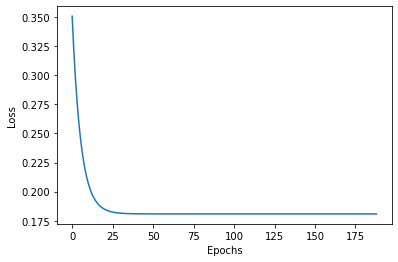

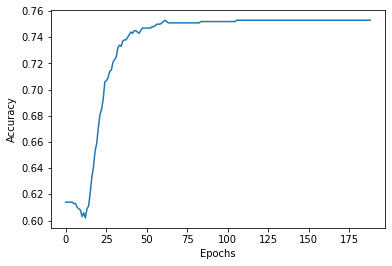

In [277]:
#Scaling the data
scaled_dataset = standard_scaler(X_train) #Scale

#Training the model on different hyperparameters

print(scaled_dataset)






c3 = NumpyLinRegClass()
c3.fit(scaled_dataset, t2_train,0.09,188)

losses_scaled = c3.lossPerEp
accuracies_scaled = c3.accuracyPerEp



x_1 = np.linspace(0,188,188)
x_2 = np.linspace(0,188,188)

plt.plot(x_1,losses_scaled)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()
plt.clf()

plt.plot(x_2,accuracies_scaled)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

    

The final hyperparameters for the scaled dataset is Epoch = 188 and eta = 0.09. This gives an accuracy of 0.753. I found it by checking the accuracy for different combinations of eta and epoch for the scaled_dataset. 


## Logistic regression
a) You should now implement a logistic regression classifier similarly to the classifier based on linear regression.
You may use code from the solution to weekly exercise set week07.

b) In addition to the method `predict` which predicts a class for the data, include a method `predict_probability` which predicts the probability of the data belonging to the positive class.

c) As with the classifier based on linear regression, we want to calculate loss and accuracy after each epoch.
The prefered loss for logistic regression is binary cross-entropy. You could have used mean squared error. The most important is that your implementation of the loss corresponds to your implementation of the gradient descent.

d) In addition, extend the fit-method with optional arguments for a validation set (X_val, t_val). If a validation set is included in the call to fit, calculate the loss and the accuracy for the validation set after each epoch. 

e) The training runs for a number of epochs. We cannot know beforehand for how many epochs it is reasonable to run the training. One possibility is to run the training until the learning does not improve much. Extend the fit-method with two keyword arguments, `tol` and `n_epochs_no_update` and stop training when the loss has not improved with more than `tol` after running `n_epochs_no_update` epochs. A possible default value for `n_epochs_no_update` is 5. Also, add an attribute to the classifier which tells us after fitting how many epochs were ran.

f) Train classifiers with various learning rates, and with varying values for `tol` for finding optimal values. Also consider the effect of scaling the data.

g) After a succesful training, plot both training loss and validation loss as functions of the number of epochs in one figure, and both accuracies as functions of the number of epochs in another figure. Comment on what you see.

In [208]:
#The logistic function
def logistic(x):
    return 1/(1+np.exp(-x))

In [209]:
class NumpyLogReg(NumpyClassifier):
    
    def __init__(self, bias=-1):
        self.bias=bias

    def fit(self, X_train, t_train, eta = 0.1, epochs=10, X_validate = [], t_validate = [],  tol = 0.001, n_epochs_no_update = 5):
        """X_train is a Nxm matrix, N data points, m features
        t_train is avector of length N,
        the targets values for the training data"""
        
        if self.bias:
            X_train = add_bias(X_train, self.bias)
            X_validate = add_bias(X_validate, self.bias)
        
        (N, m) = X_train.shape
        
        
        self.weights = weights = np.zeros(m)
    
        self.losses = []
        self.accuracies = []
        
        self.val_losses = []
        self.val_accuracies = []
        
        self.numbOfEpochs = 0
        
        for e in range(epochs):
            weights -= eta / N *  X_train.T @ (self.forward(X_train) - t_train)
            self.losses.append(self.bin_cross_entropy(X_train,t2_train))
            self.accuracies.append(self.accur(X_train,t2_train))
            
            
            self.val_losses.append(self.bin_cross_entropy(X_validate, t_validate))
            self.val_accuracies.append(self.accur(X_validate,t_validate))

        y = True
        while y:
            for i in range(len(self.losses)-1): 
                if (self.losses[i]-self.losses[i+1]) > tol:
                    continue
                else: 
                    break
            self.numbOfEpochs = i
            y = False
            
            
    
    #Loss-function for logistic
    def bin_cross_entropy(self,X,t):
        predicted = self.forward(X)
        return -np.mean(t*np.log(predicted) + (1-t)*np.log(1-predicted))
    
    #Accuracy-function
    def accur(self,X, t):
        y_pred = self.predict(X)
        return np.mean(y_pred == t)
    
    def forward(self, X):
        if X.shape[1] == 2: 
            X = add_bias(X, self.bias)
        return logistic(X @ self.weights)
    
    def predict(self, x, threshold=0.5):
        """X is a Kxm matrix for some K>=1
        predict the value for each point in X"""

        return (self.forward(x) > threshold).astype('int')
    
    def predict_probability(self,X):
        return self.forward(X)
        

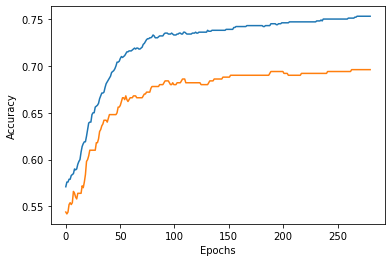

Text(0, 0.5, 'Loss')

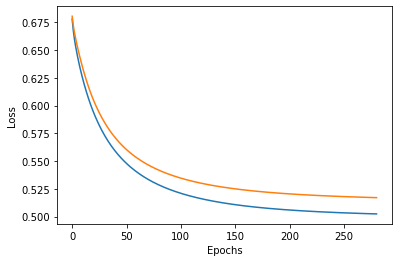

In [210]:
logCl = NumpyLogReg()
logCl.fit(X_train,t2_train,0.05,280, X_val, t2_val)


x = np.linspace(0,280, 280) #Uses 173 Epoch

losses = logCl.losses
lossesVal = logCl.val_losses
accuracy_list = logCl.accuracies

accuracyVal = logCl.val_accuracies

numb_of_ep = logCl.numbOfEpochs

plt.plot(x,accuracy_list)
plt.plot(x,accuracyVal)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()
plt.clf()

plt.plot(x,losses)
plt.plot(x,lossesVal)
plt.xlabel("Epochs")
plt.ylabel("Loss")


No need to scale the data given a Logistic Classifier. We can see that the accuracy on the training set is better than the validation set, and that the there is greater loss in the training set. 

## Multi-class classifiers
We turn to the task of classifying when there are more than two classes, and the task is to ascribe one class to each input. We will now use the set (X, t_multi).

### "One-vs-rest" with logistic regression
We saw in the lecture how a logistic regression classifier can be turned into a multi-class classifier using the one-vs-rest approach. We train one logistic regression classifier for each class. To predict the class of an item, we run all the binary classifiers and collect the probability score from each of them. We assign the class which ascribes the highest probability.

Build such a classifier. Train the resulting classifier on (X_train, t_multi_train), test it on (X_val, t_multi_val), tune the hyper-parameters and report the accuracy.

Also plot the decision boundaries for your best classifier similarly to the plots for the binary case.

In [211]:
 class MultiClassifiers(NumpyLogReg):
        
    #Creates a new fit function()
    def fit(self, X_train, t_multi_train, eta = 0.05,epochs = 280):
        
        
        self.classes = np.unique(t_multi_train) #0,1,2,3,4
        self.classifiers = []
        for c in self.classes: 
            binary_list = np.where(t_multi_train == c, 1, 0) #Creates a list where "one" is 1, and the "rest" is given 0
            classifier = NumpyLogReg()
            classifier.fit(X_train, binary_list,0.05,173, X_train, t_multi_train) #Training
            self.classifiers.append(classifier)
     
    #Finds the probabilities for the 5 classifiers, I asign the one which ascribes the highest probability. 
    def predict_probability(self, X):
        prob = []
        for c in self.classifiers:
            prob.append(c.predict_probability(X))
        return np.vstack(prob).T #Stack arrays in sequence vertically (row wise) transponed. 
            
    
    
    

In [212]:
MCl = MultiClassifiers()
MCl.fit(X_train, t_multi_train, 0.05,280)

#Array with all the predictions from the 5 classes given to each point. 
#I pick out the greatest one
array_best_prob = MCl.predict_probability(X_train)
list_best_prob = []

for prediction in array_best_prob: 
    #np.argmax returns the index of the largest element in the array
    best_prob = np.argmax(prediction)
    #The index corresponds with the class(0,1,2,3,4)
    list_best_prob.append(best_prob)

#


print(accuracy_func(list_best_prob, t_multi_train))

print(list_best_prob)
print(t_multi_train)









0.607
[3, 2, 1, 2, 2, 4, 0, 0, 4, 4, 0, 1, 2, 2, 0, 2, 4, 4, 1, 2, 1, 2, 2, 0, 2, 2, 2, 1, 4, 1, 4, 0, 4, 2, 4, 2, 4, 3, 1, 0, 4, 2, 4, 4, 4, 0, 1, 4, 1, 2, 1, 4, 2, 1, 0, 4, 1, 4, 1, 3, 4, 4, 4, 2, 2, 0, 2, 4, 2, 4, 0, 1, 2, 2, 0, 0, 0, 4, 1, 1, 0, 0, 4, 0, 2, 0, 1, 2, 2, 2, 0, 4, 4, 0, 0, 4, 0, 2, 1, 2, 4, 0, 2, 1, 1, 4, 2, 4, 1, 2, 4, 4, 2, 2, 2, 2, 4, 0, 2, 1, 2, 1, 1, 2, 2, 2, 3, 0, 4, 2, 2, 2, 0, 0, 3, 2, 0, 1, 4, 4, 2, 2, 2, 3, 1, 4, 0, 2, 4, 3, 3, 1, 1, 0, 3, 4, 1, 2, 1, 0, 0, 1, 1, 4, 2, 4, 2, 2, 4, 1, 1, 2, 0, 4, 4, 2, 2, 2, 4, 0, 4, 0, 1, 4, 0, 2, 1, 2, 1, 4, 4, 1, 2, 2, 2, 3, 1, 1, 1, 2, 2, 0, 0, 1, 1, 0, 0, 1, 0, 3, 1, 4, 4, 3, 1, 0, 0, 0, 2, 0, 2, 1, 2, 0, 0, 2, 3, 2, 2, 4, 4, 4, 2, 3, 4, 1, 1, 2, 2, 3, 0, 4, 2, 1, 2, 4, 0, 4, 2, 2, 1, 0, 2, 0, 2, 2, 4, 4, 4, 0, 2, 0, 2, 3, 4, 2, 1, 0, 4, 2, 2, 0, 0, 3, 0, 0, 4, 0, 4, 4, 3, 2, 2, 1, 4, 0, 3, 4, 1, 3, 2, 2, 1, 4, 4, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 2, 2, 0, 1, 2, 2, 4, 2, 2, 2, 4, 3, 4, 4, 2, 2, 3, 0, 2, 2, 0, 4, 4, 4, 2, 3, 

The accuracy for the one vs rest approach is 0.687. 

### For in4050-students: Multi-nominal logistic regression
The following part is only mandatory for in4050-students. In3050-students are also welcome to make it a try. Everybody has to return for the part 2 on multi-layer neural networks. 

In the lecture, we contrasted the one-vs-rest approach with the multinomial logistic regression, also called softmax classifier. Implement also this classifier, tune the parameters, and compare the results to the one-vs-rest classifier. 

Remember that this classifier uses softmax in the forward phase. For loss, it uses categorical cross-entropy loss. The loss has a somewhat simpler form than in the binary case. To calculate the gradient is a little more complicated. The actual gradient and update rule is simple, however, as long as you have calculated the forward values correctly.

# Part II Multi-layer neural networks

## A first non-linear classifier

The following code it a simple implementation of a multi-layer perceptron.
It is quite restricted.
There is only one hidden layer.
It can only handle binary classification.
In addition, it uses a simple final layer similar to the linear regression classifier above.
One way to look at it is what happens when we add a hidden layer to the linear regression classifier.

It can be used to make a non-linear classifier for the set (X, t2).
Experiment with settings for learning rate and epochs and see how good results you can get.
Report results for variouse settings.
Be prepared to train for a looooong time.
Plot the training set together with the decision regions as in part I.

In [213]:
class MLPBinaryLinRegClass(NumpyClassifier):
    """A multi-layer neural network with one hidden layer"""
    
    def __init__(self, bias=-1, dim_hidden = 6):
        """Intialize the hyperparameters""" 
        self.bias = bias
        self.dim_hidden = dim_hidden
        
        def logistic(x):
            return 1/(1+np.exp(-x))
        self.activ = logistic

        def logistic_diff(y): 
            return y * (1 - y)
        self.activ_diff = logistic_diff
    
    def fit(self, X_train, t_train, eta=0.001, epochs = 100):
        """Intialize the weights. Train *epochs* many epochs.
        
        X_train is a Nxm matrix, N data points, m features
        t_train is a vector of length N of targets values for the training data,
        where the values are 0 or 1. """
        
        self.eta = eta
        
        T_train = t_train.reshape(-1,1)
        
        dim_in = X_train.shape[1]
        dim_out = T_train.shape[1]

        # Initialize the weights
        self.weights1 = (np.random.rand(dim_in + 1,
            self.dim_hidden) * 2 - 1)/np.sqrt(dim_in)
        
        self.weights2 = (np.random.rand(
            self.dim_hidden+1,
            dim_out) * 2 - 1)/np.sqrt(self.dim_hidden)
        
        X_train_bias = add_bias(X_train, self.bias)
        
        
        for e in range(epochs): 
            # One epoch
            hidden_outs, outputs = self.forward(X_train_bias) 
            # The forward step
            out_deltas = (outputs - T_train)
            # The delta term on the output node 
            hiddenout_diffs = out_deltas @ self.weights2.T
            # The delta terms at the output of the jidden layer
            hiddenact_deltas = (hiddenout_diffs[:, 1:] *
                                self.activ_diff(hidden_outs[:, 1:]))
            # The deltas at the input to the hidden layer
            self.weights2 -= self.eta * hidden_outs.T @ out_deltas 
            self.weights1 -= self.eta * X_train_bias.T @ hiddenact_deltas 
            # Update the weights

    def forward(self, X):
        """Perform one forward step.
        Return a pair consisting of the outputs of the hidden_layer and the outputs on the final layer"""
        hidden_activations = self.activ(X @ self.weights1) 
        hidden_outs = add_bias(hidden_activations, self.bias) 
        outputs = hidden_outs @ self.weights2
        return hidden_outs, outputs
        
    def predict(self, X):
        """Predict the class for the mebers of X""" 
        Z = add_bias(X, self.bias)
        forw = self.forward(Z)[1]
        score= forw[:, 0]
        return (score > 0.5)
        
        
        
        
        
        

In [214]:
eta_list=[0.005,0.001,0.0005,0.0001] 
epoch_list=[10000,15000,20000]

best_eta, best_epoch = 0,0
best_accuracy = 0

for epoch in epoch_list:
    for eta in eta_list: 
        MLPB=MLPBinaryLinRegClass() 
        MLPB.fit(X_train,t2_train,eta,epoch)
        acc=np.mean(MLPB.predict(X_train)==t2_train)
        
        if acc > best_accuracy: 
            best_accuracy = acc
            best_eta = eta
            best_epoch = epoch
print(f' Best Eta: {best_eta} Best Epoch: {best_epoch}')
print(f' Accuracy: {best_accuracy}')


<ipython-input-213-7070f215a1b8>:10: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
<ipython-input-213-7070f215a1b8>:48: RuntimeWarning: overflow encountered in matmul
  hiddenout_diffs = out_deltas @ self.weights2.T
<ipython-input-213-7070f215a1b8>:50: RuntimeWarning: invalid value encountered in multiply
  hiddenact_deltas = (hiddenout_diffs[:, 1:] *


 Best Eta: 0.0005 Best Epoch: 15000
 Accuracy: 0.887


I found that the best hyperparameters are Eta: 0.0005 and Epoch 15000: , which gives an accuracy of 0.887


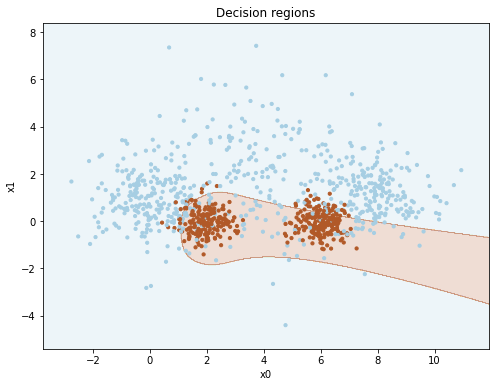

In [216]:
#I plot the descision boundaries for MLP with best hyperparameters
MLP_best=MLPBinaryLinRegClass()
MLP_best.fit(X_train,t2_train,0.0005,15000)
plot_decision_regions(X_train,t2_train,MLP_best)

As we can see, this is way better then for the other classifiers (probably because the data is not linearly separable)

## Improving the classifier
You should now make changes to the classifier similarly to what you did with the logistic regression classifier in part 1.

a) In addition to the method predict, which predicts a class for the data, include a method predict_probability which predict the probability of the data belonging to the positive class. The training should be based on this value as with logistic regression.

b) Calculate the loss and the accuracy after each epoch and store them for inspection after training.

c) In addition, extend the fit-method with optional arguments for a validation set (X_val, t_val). If a validation set is included in the call to fit, calculate the loss and the accuracy for the validation set after each epoch.

d) The training runs for a number of epochs. We cannot know beforehand for how many epochs it is reasonable to run the training. One possibility is to run the training until the learning does not improve much. Extend the fit method with two keyword arguments, `tol` and `n_epochs_no_update` and stop training when the loss has not improved with more than tol after `n_epochs_no_update`. A possible default value for `n_epochs_no_update` is 5. Also, add an attribute to the classifier which tells us after fitting how many epochs were ran.

e) Tune the hyper-parameters:`eta`, `tol`and `dim-hidden`.
Also consider the effect of scaling the data.

f) After a succesful training with a best setting for the hyper-parameters, plot both training loss and validation loss as functions of the number of epochs in one figure, and both accuracies as functions of the number of epochs in another figure. Comment on what you see.

g) The algorithm contains an element of non-determinism. Hence, train the classifier 10 times with the optimal hyper-parameters and report the mean and standard deviation of the accuracies over the 10 runs.

In [237]:
class MLPBinaryLinRegClass_Better(NumpyClassifier):
    """A multi-layer neural network with one hidden layer"""
    
    def __init__(self, bias=-1, dim_hidden = 6):
        """Intialize the hyperparameters""" 
        self.bias = bias
        self.dim_hidden = dim_hidden
        
        def logistic(x):
            return 1/(1+np.exp(-x))
        self.activ = logistic

        def logistic_diff(y): 
            return y * (1 - y)
        self.activ_diff = logistic_diff
    
    def mse(self,X,t):
        return np.mean((X-t)**2)

    
    def fit(self, X_train, t_train, eta=0.001,X_val = [], t_val = [], tol = 1e-05, n_epochs_no_update=5):
        """Intialize the weights. Train *epochs* many epochs.
        
        X_train is a Nxm matrix, N data points, m features
        t_train is a vector of length N of targets values for the training data,
        where the values are 0 or 1. """
        
        self.eta = eta
        
        T_train = t_train.reshape(-1,1)
        
        dim_in = X_train.shape[1]
        dim_out = T_train.shape[1]
        
        X_train_bias = add_bias(X_train, self.bias)
        if len(X_val)!=0:
            X_val=add_bias(X_val,self.bias) #Adding bias to the X_val if it is included

        # Initialize the weights
        self.weights1 = (np.random.rand(dim_in + 1,
            self.dim_hidden) * 2 - 1)/np.sqrt(dim_in)
        
        self.weights2 = (np.random.rand(
            self.dim_hidden+1,
            dim_out) * 2 - 1)/np.sqrt(self.dim_hidden)
        
    
        #Loss list for the training and validation data
        
        self.loss_epoch=[] 
        self.accuracy_epoch=[] 
        self.loss_epoch_val=[] 
        self.accuracy_epoch_val=[]
        
        #used for while-loop
        y =True 
        epoch_numb=0 
        no_update=0
        
        #I run a while loop while the MLP still learns. If there is 5 epochs without learning(less than tol)
        #It stops
        while y:
            
            if len(X_val)!=0 and len(t_val)!=0:
                
                outputs_val=self.forward(X_val)[1] 
                loss_val=self.mse(outputs_val,t_val) 
                self.loss_epoch_val.append(loss_val) 
                
                accuracy_val=np.mean(self.predict(X_val,addBias=False)==t_val) 
                self.accuracy_epoch_val.append(accuracy_val)
        
            acc=np.mean(self.predict(X_train_bias,addBias=False)==t_train) 
            self.accuracy_epoch.append(acc)

            hidden_outs, outputs = self.forward(X_train_bias)
            loss_training=self.mse(outputs,T_train)
            self.loss_epoch.append(loss_training)
             
            # The forward step
            out_deltas = (outputs - T_train)
            # The delta term on the output node 
            hiddenout_diffs = out_deltas @ self.weights2.T
            # The delta terms at the output of the jidden layer
            hiddenact_deltas = (hiddenout_diffs[:, 1:] *
                                self.activ_diff(hidden_outs[:, 1:]))
            # The deltas at the input to the hidden layer
            self.weights2 -= self.eta * hidden_outs.T @ out_deltas 
            self.weights1 -= self.eta * X_train_bias.T @ hiddenact_deltas 
            # Update the weights
            
            #How to check if there has been 2 epochs, because if not, we can not compare the loss to the tol. 
            if epoch_numb>=2 and abs(self.loss_epoch[epoch_numb-1]-self.loss_epoch[epoch_numb-2])<tol:
                no_update+=1 
            else:
                no_update=0 
                
            if(no_update>=n_epochs_no_update):
                y =False 
            
            epoch_numb+=1
        #The amount of epochs for the training, which is assigned after the while-loop is done.     
        self.epoch_numb=epoch_numb


    def forward(self, X):
        """Perform one forward step.
        Return a pair consisting of the outputs of the hidden_layer and the outputs on the final layer"""
        hidden_activations = self.activ(X @ self.weights1) 
        hidden_outs = add_bias(hidden_activations, self.bias) 
        outputs = hidden_outs @ self.weights2
        return hidden_outs, outputs
    
    #Added a addBias parameter, to get the right dimensions. 
    def predict(self, X,addBias=True):
        """Predict the class for the mebers of X""" 
        if addBias:
            X = add_bias(X, self.bias)
        forw = self.forward(X)[1]
        score= forw[:, 0]
        return (score > 0.5).astype("int")#Instead of True/False

    
    #Predicts he probability of the data belonging to the positive class.
    def predict_probability(self,X): 
        Z=add_bias(X,self.bias) 
        forw=self.forward(Z)[1] 
        probability=forw[:,0] 
        return probability
        

In [238]:
#Tuning the settings

dim_list=[6,7,8,9,10]
eta_list=[0.0005,0.0001,0.00005] 
tol_list=[1e-03,1e-04,1e-05,1e-06] 


best_eta, best_dim, best_tol = 0,0,0
best_accuracy = 0
# Triple for-loop, to iterate over each combination
for dim in dim_list:
    for eta in eta_list: 
        for tol in tol_list:
            MLP=MLPBinaryLinRegClass_Better(dim_hidden=dim)
            MLP.fit(X_train,t2_train,eta=eta,tol=tol)
            acc=np.mean(MLP.predict(X_train)==t2_train) 
            #Check if it's better than the current best accuracy
            if acc > best_accuracy: 
                best_accuracy = acc
                best_eta, best_dim, best_tol = eta, dim, tol


print(f'Eta = {best_eta} Tol: {best_tol} Dim: {best_dim}')
print(best_accuracy)

Eta = 0.0005 Tol: 1e-06 Dim: 10
0.917


Best accuracy is 0.917 with eta = 0.0005, tol = 1e-06 and Dim 10. 


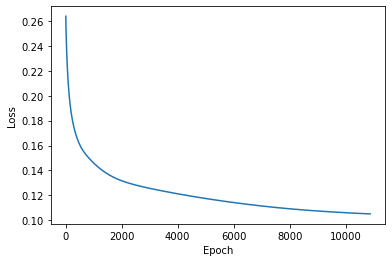

Text(0, 0.5, 'Accuracy')

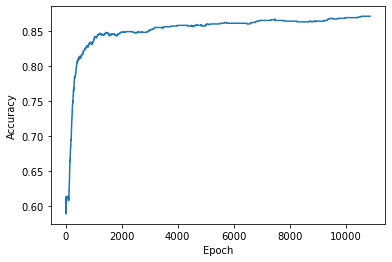

In [241]:
#Plotting loss and accuracy for given epochs fir the MLP. 
epochs=MLP.epoch_numb
x = np.linspace(0,epochs,epochs)

plt.plot(x,MLP.loss_epoch)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.plot(x,MLP.accuracy_epoch,label="Training accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

Here we can see that the loss decreases with higher epoch, but that it stabilizes. 

In [245]:
#Asked to train the classifier 10 times with the best hyperparameters and finding the mean and standard deviation
accuracies=np.zeros(10) 
for i in range(10):
    #Training with the parameters found earlier
    MLP=MLPBinaryLinRegClass_Better(dim_hidden=10)
    MLP.fit(X_train,t2_train,eta=0.0005,tol=1e-05,X_val=X_val,t_val=t2_val)
    #the accuracy is accessed from the accuracy_list_val
    accuracies[i]=MLP.accuracy_epoch_val[-1]
    
print("Data over 10 runs: ")
print(f"Mean accuracy: {np.mean(accuracies):.2f}") 
print(f"Standard deviation: {np.std(accuracies):.2f}")

Data over 10 runs: 
Mean accuracy: 0.87
Standard deviation: 0.02


The Mean accuracy over 10 runs is 0.87, with a standatd deviation of 0.02. We did this due to the fact that there is some randomnes involved. I didnt have time to train it with tol = 1e-06, as this took a loooong time. 

## For IN4050-students: Multi-class neural network

The following part is only mandatory for in4050-students. In3050-students are also welcome to make it a try. (This is the most fun part of the set :) )

The goal is to use a feed-forward network for non-linear multi-class classfication and apply it to set (X, t_multi).

Modify the netork to become a multi-class classifier. As a check of your implementation, you may apply it to (X, t_2) and see whether you get similar results as above.

Train the resulting classifier on (X_train, t_multi_train), test it on (X_val, t_multi_val), tune the hyper-parameters and report the accuracy.

Plot the decision boundaries for your best classifier..

# Part III: Final testing
We can now perform a final testing on the held-out test set.

## Binary task (X, t2)
Consider the linear regression classifier, the logistic regression classifier and the multi-layer network with the best settings you found. Train each of them on the training set and calculate accuracy on the held-out test set, but also on the validation set and the training set. Report in a 3 by 3 table.

Comment on what you see. How do the three different algorithms compare? Also, compare the results between the different data sets. In cases like these, one might expect slightly inferior results on the held-out test data compared to the validation data. Is that the case here? 

Also report precision and recall for class 1.

## For IN4050-students: Multi-class task (X, t_multi)
The following part is only mandatory for in4050-students. In3050-students are also welcome to do it. It requires the earlier IN4050-only tasks. 

Compare the three multi-class classfiers, the one-vs-rest and the multinomial logistic regression from part one, and the multi-class neural network from part two. Evaluate on test, validation and training set as above. 

Comment on what you see

In [247]:
linReg = NumpyLinRegClass()
linReg.fit(X_train, t2_train,0.05,280)

acc_linReg_X_train = accuracy_func(linReg.predict(X_train), t2_train)
acc_linReg_X_val = accuracy_func(linReg.predict(X_val), t2_val)
acc_linReg_X_test = accuracy_func(linReg.predict(X_test), t2_test)


logReg = NumpyLogReg()
logReg.fit(X_train, t2_train, 0.05, 280, X_val, t2_val)

logRegX_train = accuracy_func(logReg.predict(X_train), t2_train)
logRegX_val = accuracy_func(logReg.predict(X_val), t2_val)
logRegX_test = accuracy_func(logReg.predict(X_test), t2_test)


MLPB = MLPBinaryLinRegClass_Better(dim_hidden=10)
MLPB.fit(X_train,t2_train,eta=0.0005,tol=1e-06)
MLPB_X_train = accuracy_func(MLPB.predict(X_train), t2_train)
MLPB_X_val = accuracy_func(MLPB.predict(X_val), t2_val)
MLPB_X_test = accuracy_func(MLPB.predict(X_test), t2_test)


print("              Training Validation Testing")
print(f'LinReg:       {acc_linReg_X_train}       {acc_linReg_X_val}    {acc_linReg_X_test} ')
print(f'LogReg:       {logRegX_train}       {logRegX_val}    {logRegX_test} ')
print(f'MLP:          {MLPB_X_train}       {MLPB_X_val}     {MLPB_X_test}  ')




              Training Validation Testing
LinReg:       0.751       0.704    0.724 
LogReg:       0.753       0.696    0.722 
MLP:          0.91       0.916     0.914  


We can observe that the Multi-Layer Perceptron is the best classifier. This is not shocking, as we have seen throughout the task that the data is not linear separable. I was surprised that it dit so well on the test data. I also observed that the the validation set for all three classifiers did worse than the test-set.